In [1]:
def run_simulation_2D(x, y, nx, ny, Lx, Ly, cx, cy, sx, sy):
    dx, dy = Lx/(nx-1), Ly/(ny-1)
    dt = 1
    tend = 1200
    t = 0

    cfl_x, cfl_y = cx * dt/dx, cy * dt/dy
    diff_x, diff_y = sx * dt/dx**2, sy * dt/dy**2

    u = np.zeros((nx+2, ny+2))
    sol = []
    source_x, source_y = nx // 2, ny // 2
    # Q = 1e-6
    u[source_x, source_y] = 1.0 # Cocentration starts from the central peak
    
    while t < tend:
        unew = u.copy()
        sol.append(u[1:-1, 1:-1])

         # Advection (Upwind Scheme)
        unew[1:-1, 1:-1] -= cfl_x * (u[1:-1, 1:-1] - u[1:-1, :-2])
        unew[1:-1, 1:-1] -= cfl_y * (u[1:-1, 1:-1] - u[:-2, 1:-1])
    
        # Diffusion (Central Differencing)
        unew[1:-1, 1:-1] += diff_x * (u[1:-1, 2:] - 2*u[1:-1, 1:-1] + u[1:-1, :-2])
        unew[1:-1, 1:-1] += diff_y * (u[2:, 1:-1] - 2*u[1:-1, 1:-1] + u[:-2, 1:-1])

        # # Source Term
        # unew[source_x, source_y] += Q * dt

        # Additional Source Points (forming a small area)
        # offsets = [(-1, -1), (-1, 1), (1, -1), (1, 1), (-1, 0), (1, 0), (0, -1), (0, 1)]
        # for dx, dy in offsets:
        #     unew[source_x + dx, source_y + dy] += Q * dt

        u = unew
        t += dt

    '''
    We transpose the axis the solution. Such that:
    - Axis 0: x
    - Axis 1: y
    - Axis 2: time
    Interpretation: For each x-grid, we have the concentration of each y-grid over time.
    Essentially, the (ny, 1200) array represents the concentration at each y over the time.
    So we have an array of size 1200 for each y. (A curve)
    '''
    sol = np.transpose(sol, (1, 2, 0))
    return np.array(sol)

In [2]:
from joblib import Parallel, delayed
import numpy as np
import time as time

nx, ny= 51, 51  # Grid points
Lx, Ly = 5000, 5000  # Domain size in meters
x = np.linspace(-2500, 2500, nx)  # Centered at (0,0)
y = np.linspace(-2500, 2500, ny)
n = 50
cx, cy = np.random.RandomState().uniform(0, 10, n), np.random.RandomState().uniform(0, 10, n)
sx, sy = np.random.RandomState().uniform(0, 1, n), np.random.RandomState().uniform(0, 1, n)
num_cores = -1

start_time = time.time()
results = Parallel(n_jobs=num_cores)(
    delayed(run_simulation_2D)(x, y, nx, ny, Lx, Ly, cx[i], cy[i], sx[i], sy[i])
    for i in range(n)
)
end_time = time.time()

print(f"Simulation took: {end_time-start_time}")

Simulation took: 2.5812792778015137


In [6]:
cx

array([8.16760679, 3.98210491, 4.54005281, 4.30543137, 1.88336451,
       8.57577046, 6.91091517, 4.5443337 , 7.43821917, 0.35092192,
       2.09344519, 2.67110659, 7.96433436, 2.69557545, 4.35247981,
       9.55797578, 7.82864236, 8.5383889 , 3.66791323, 3.38051615,
       1.73442279, 9.44430598, 5.24745463, 2.76110675, 9.17430879,
       3.19574918, 1.62340533, 9.22066083, 0.82830552, 0.58969078,
       7.5863776 , 2.15142566, 7.91343577, 3.10440534, 5.90237998,
       9.21057049, 2.06997159, 5.10227104, 5.7132966 , 1.14178563,
       7.32076184, 9.42795805, 0.02357765, 1.1036563 , 5.4519726 ,
       1.12765042, 7.48203825, 4.7797339 , 0.78741189, 4.02616269])

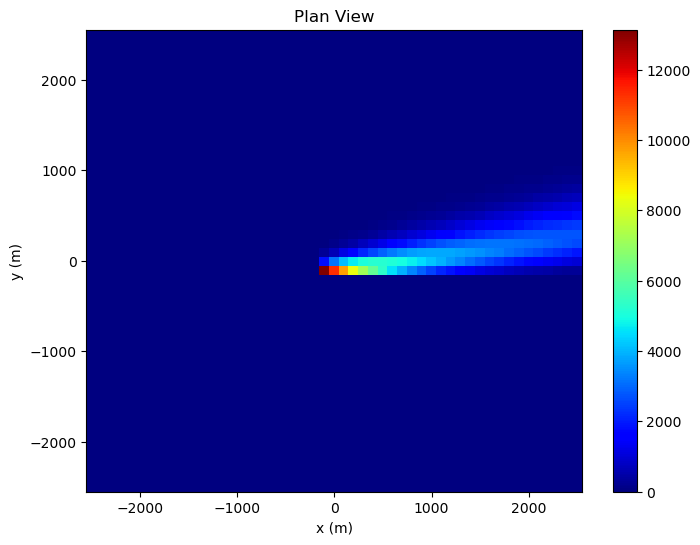

In [11]:
import matplotlib.pyplot as plt

sim_plot = results[-6]
X, Y = np.meshgrid(x, y)
plt.figure(figsize=(8,6))
plt.pcolor(X, Y, np.mean(sim_plot, axis=2) * 1e6, cmap='jet', shading='auto')
plt.colorbar()
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Plan View")
plt.show()

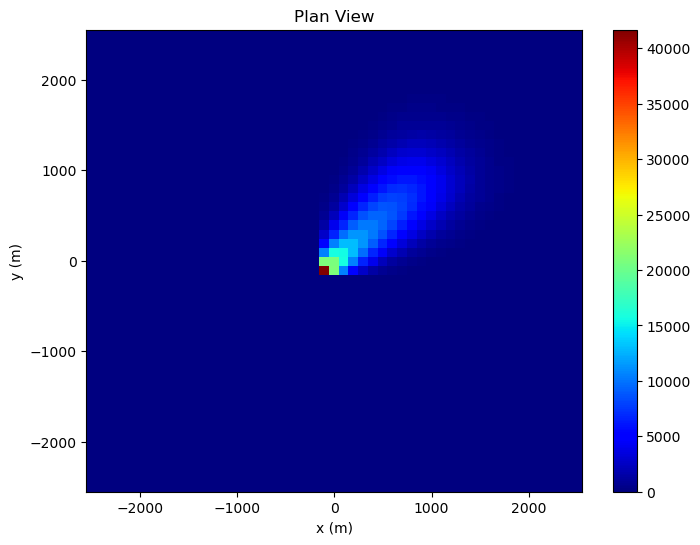

In [72]:
temp = run_simulation_2D(x, y, nx, ny, Lx, Ly, 1, 1, 10e-4, 10e-4)
X, Y = np.meshgrid(x, y)
plt.figure(figsize=(8,6))
plt.pcolor(X, Y, np.mean(temp, axis=2) * 1e6, cmap='jet', shading='auto')
plt.colorbar()
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Plan View")
plt.show()

## Applying Distance Metrics

We try to implement the same way as we have for the 1D problem, and adjust if there are any issues.

Because the shape of the results would be in 4D (n, Nx, Ny, time), it would be infeasible to try and solve everything all at once.

However, parallelisation can still be utilised.

The distances should be modified such that it computes the distance **for each spatial location** across time first (outputting a 51x51 matrix), with each (i, j) representating the distance at that point, and then output an average (?).

The original distance metrics were desgined so that it computes the distance between each column.
- This is because each column represented one solution.

In [43]:
observed = np.load("observed_data/no_noise/no_noise.npy")
observed.shape

(51, 51, 1200)

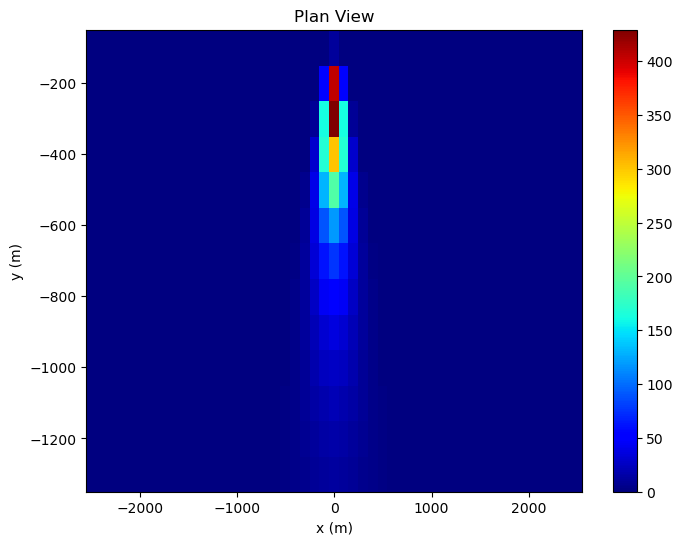

In [71]:
filtered = observed[12:25, :, :]
tempx = x
tempy = y[12:25]
tempX, tempY = np.meshgrid(tempx, tempy)
plt.figure(figsize=(8,6))
plt.pcolor(tempX, tempY, np.mean(filtered, axis=2) * 1e6, cmap='jet', shading='auto')
plt.colorbar()
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Plan View")
plt.show()

### Wasserstein

In [14]:
### Original ###
def wasserstein_distance(simulated_sample: np.ndarray, observed_sample: np.ndarray) -> float:
    # Mean Difference between simulated and observed
    simulated_sorted = np.sort(simulated_sample, axis=0)
    observed_sorted = np.sort(observed_sample, axis=0)
    distance = np.mean(np.abs(simulated_sorted - observed_sorted), axis=0)

    return distance

### Modified ###
def wasserstein_distance_3D(simulated_sample: np.ndarray, observed_sample: np.ndarray) -> np.ndarray:
    """
    Compute the Wasserstein distance between two (51, 51, 1200) shaped arrays 
    along the time dimension.

    Sorted along the time axis, we now have a (51, 51, 1200) array, with each 1200-sized array sorted ascendingly 

    Returns a (51, 51) array of distances for each spatial location.
    """
    # Sort along the time axis (axis=2)
    simulated_sorted = np.sort(simulated_sample, axis=2)
    observed_sorted = np.sort(observed_sample, axis=2)

    # Compute the mean absolute difference along the time axis
    distance = np.mean(np.abs(simulated_sorted - observed_sorted), axis=2)

    return distance 

In [15]:
start = time.time()
wass = Parallel(n_jobs=num_cores)(
    delayed(wasserstein_distance_3D)(results[i], observed)
    for i in range(n)
)
end = time.time()
end-start

8.141800165176392

### CvMD

In [28]:
### Original ###
def cramer_von_mises(simulated_sample: np.ndarray, observed_sample: np.ndarray) -> float:
    if len(simulated_sample) != len(observed_sample):
        return "Size of samples not equal."
    
    nrow = simulated_sample.shape[0]
    ncol = simulated_sample.shape[1]
    combined = np.concatenate((simulated_sample, observed_sample))
    # Find corresponding ranks in h associated with simulated/observed
    combined_rank = np.argsort(combined, axis=0)+1
    simulated_rank = combined_rank[:nrow]
    observed_rank = combined_rank[nrow:]

    # Calculate distance
    idx = np.tile(np.arange(1, nrow+1), (ncol, 1)).T
    observed_sum = np.sum((observed_rank - idx)**2, axis=0)
    simulated_sum = np.sum((simulated_rank - idx)**2, axis=0)
    rank_sum = nrow * (observed_sum + simulated_sum)
    distance = rank_sum / (2*nrow**3) - (4*nrow**2 - 1)/(12*nrow)

    return distance

### Modified ###
def cramer_von_mises_3d(simulated_sample: np.ndarray, observed_sample: np.ndarray) -> np.ndarray:
    '''
    Outputs a (51, 51), representing CvMD at each grid point.
    '''
    if simulated_sample.shape != observed_sample.shape:
        raise ValueError("Shape of samples not equal.")
    
    x_dim, y_dim, n_samples = simulated_sample.shape
    cvm_matrix = np.zeros((x_dim, y_dim))

    # Comparing the (1200,)-shaped array for each (x, y) grid point
    for i in range(x_dim):
        for j in range(y_dim):
            sim = simulated_sample[i, j, :]
            obs = observed_sample[i, j, :]

            # Combining the two arrays. (2400,)-shaped array
            combined = np.concatenate((sim, obs))
            # np.argsort(combined) gives us indicies that would sort the combined array in ascending order.
            # applying np.argosrt again gives us the rank of each element in the original array.
            combined_rank = np.argsort(np.argsort(combined)) + 1

            # First half of the combined rank is simulated by definition of combined.
            sim_rank = combined_rank[:n_samples]
            obs_rank = combined_rank[n_samples:]

            # Calculation for CvMD
            idx = np.arange(1, n_samples + 1)
            obs_sum = np.sum((obs_rank - idx) ** 2)
            sim_sum = np.sum((sim_rank - idx) ** 2)
            
            rank_sum = n_samples * (obs_sum + sim_sum)
            distance = rank_sum / (2 * n_samples**3) - (4 * n_samples**2 - 1) / (12 * n_samples)
            
            cvm_matrix[i, j] = distance
    
    return cvm_matrix

In [29]:
start = time.time()
cvmd = Parallel(n_jobs=num_cores)(
    delayed(cramer_von_mises_3d)(results[i], observed)
    for i in range(n)
)
end = time.time()
end-start

2.9667017459869385

### Functional Frechet Distance

In [4]:
def _c(ca, i, j, p, q):

    if ca[i, j] > -1:
        return ca[i, j]
    elif i == 0 and j == 0:
        ca[i, j] = np.linalg.norm(p[i]-q[j])
    elif i > 0 and j == 0:
        ca[i, j] = max(_c(ca, i-1, 0, p, q), np.linalg.norm(p[i]-q[j]))
    elif i == 0 and j > 0:
        ca[i, j] = max(_c(ca, 0, j-1, p, q), np.linalg.norm(p[i]-q[j]))
    elif i > 0 and j > 0:
        ca[i, j] = max(
            min(
                _c(ca, i-1, j, p, q),
                _c(ca, i-1, j-1, p, q),
                _c(ca, i, j-1, p, q)
            ),
            np.linalg.norm(p[i]-q[j])
            )
    else:
        ca[i, j] = float('inf')

    return ca[i, j]


def frdist(p, q):
    """
    Computes the discrete Fréchet distance between
    two curves. The Fréchet distance between two curves in a
    metric space is a measure of the similarity between the curves.
    The discrete Fréchet distance may be used for approximately computing
    the Fréchet distance between two arbitrary curves,
    as an alternative to using the exact Fréchet distance between a polygonal
    approximation of the curves or an approximation of this value.

    This is a Python 3.* implementation of the algorithm produced
    in Eiter, T. and Mannila, H., 1994. Computing discrete Fréchet distance.
    Tech. Report CD-TR 94/64, Information Systems Department, Technical
    University of Vienna.
    http://www.kr.tuwien.ac.at/staff/eiter/et-archive/cdtr9464.pdf

    Function dF(P, Q): real;
        input: polygonal curves P = (u1, . . . , up) and Q = (v1, . . . , vq).
        return: δdF (P, Q)
        ca : array [1..p, 1..q] of real;
        function c(i, j): real;
            begin
                if ca(i, j) > −1 then return ca(i, j)
                elsif i = 1 and j = 1 then ca(i, j) := d(u1, v1)
                elsif i > 1 and j = 1 then ca(i, j) := max{ c(i − 1, 1), d(ui, v1) }
                elsif i = 1 and j > 1 then ca(i, j) := max{ c(1, j − 1), d(u1, vj) }
                elsif i > 1 and j > 1 then ca(i, j) :=
                max{ min(c(i − 1, j), c(i − 1, j − 1), c(i, j − 1)), d(ui, vj ) }
                else ca(i, j) = ∞
                return ca(i, j);
            end; /* function c */

        begin
            for i = 1 to p do for j = 1 to q do ca(i, j) := −1.0;
            return c(p, q);
        end.

    Parameters
    ----------
    P : Input curve - two dimensional array of points
    Q : Input curve - two dimensional array of points

    Returns
    -------
    dist: float64
        The discrete Fréchet distance between curves `P` and `Q`.

    Examples
    --------
    >>> from frechetdist import frdist
    >>> P=[[1,1], [2,1], [2,2]]
    >>> Q=[[2,2], [0,1], [2,4]]
    >>> frdist(P,Q)
    >>> 2.0
    >>> P=[[1,1], [2,1], [2,2]]
    >>> Q=[[1,1], [2,1], [2,2]]
    >>> frdist(P,Q)
    >>> 0
    """
    p = np.array(p, np.float64)
    q = np.array(q, np.float64)

    len_p = len(p)
    len_q = len(q)

    if len_p == 0 or len_q == 0:
        raise ValueError('Input curves are empty.')
        
    ca = (np.ones((len_p, len_q), dtype=np.float64) * -1)

    dist = _c(ca, len_p-1, len_q-1, p, q)
    return dist

In [8]:
start = time.time()
frdist(results[0][0, 0], observed[0, 0])
end = time.time()
print(end-start)

7.418493032455444


One iteration of this takes ~7.5 seconds, and we have to go through 51x51 of this just for one simulation. The general workflow is to compute the double loops. But this will take too long because it is in $O(nm)$, and in this case $n=m=1200$. 

One way to reduce computational time is through Downsampling + Parallelisation.

In [6]:
from scipy.signal import resample
from joblib import Parallel, delayed

def frechet_distance_dp(P, Q):
    """Computes the discrete Fréchet distance using Dynamic Programming."""
    n, m = len(P), len(Q)
    ca = np.full((n, m), np.inf)

    ca[0, 0] = np.linalg.norm(P[0] - Q[0])

    for i in range(1, n):
        ca[i, 0] = max(ca[i - 1, 0], np.linalg.norm(P[i] - Q[0]))
    for j in range(1, m):
        ca[0, j] = max(ca[0, j - 1], np.linalg.norm(P[0] - Q[j]))

    for i in range(1, n):
        for j in range(1, m):
            ca[i, j] = max(min(ca[i - 1, j], ca[i - 1, j - 1], ca[i, j - 1]), np.linalg.norm(P[i] - Q[j]))

    return ca[n - 1, m - 1]

# Downsampling function
def downsample_trajectory(traj, new_size=300):
    """Resamples a 1D trajectory to a smaller number of points."""
    return resample(traj, new_size)

# Define the downsampling size (e.g., 300 points instead of 1200)
DOWNSAMPLE_SIZE = 300

# Downsample all trajectories
sim_ds = np.apply_along_axis(downsample_trajectory, 2, results[0], DOWNSAMPLE_SIZE)
obs_ds = np.apply_along_axis(downsample_trajectory, 2, observed, DOWNSAMPLE_SIZE)

def compute_frechet(i, j):
    return frechet_distance_dp(sim_ds[i, j, :], obs_ds[i, j, :])

# # Parallel computing
# start = time.time()
# frechet_distances = np.array(
#     Parallel(n_jobs=-1, backend="loky")(delayed(compute_frechet)(i, j) for i in range(51) for j in range(51))
# ).reshape(51, 51)
# end = time.time()
# print(end-start)

# # Aggregate results
# max_distance = np.max(frechet_distances)
# mean_distance = np.mean(frechet_distances)

# print(f"Max Fréchet Distance: {max_distance}")
# print(f"Mean Fréchet Distance: {mean_distance}")

In [12]:
from discrete_frechet.distances.discrete import FastDiscreteFrechetSparse, FastDiscreteFrechetMatrix
from discrete_frechet.distances.discrete import euclidean

fdfdm = FastDiscreteFrechetMatrix(euclidean)

In [23]:
obs_ds[0,:,:].shape, sim_ds[0,:,:].shape

((51, 300), (51, 300))

In [25]:
fdfdm.distance(results[0][0,:,:], observed[0,:,:])

0.0036413390738710577

In [ ]:
frechet_distances = np.array(
    Parallel(n_jobs=-1, backend="loky")(delayed(fdfdm.distance(results[)))
)

### Hausdorff Distance

In [4]:
from scipy.spatial import cKDTree

def directed_hausdorff(A, B):
    """
    Compute the directed Hausdorff distance from set A to set B using cKDTree for efficiency.
    
    Parameters:
    A (numpy array): Set of points (N x d) where N is the number of points, and d is the dimension.
    B (numpy array): Set of points (M x d), where M is the number of points in B.
    
    Returns:
    float: The directed Hausdorff distance from A to B.
    """
    # Reshape (51, 51, 1200) -> (2601, 1200)
    A_flat = A.reshape(-1, A.shape[-1])  # (2601, 1200)
    B_flat = B.reshape(-1, B.shape[-1])  # (2601, 1200)
    
    tree_B = cKDTree(B_flat)  # Build KD-tree for set B
    dists_A_to_B, _ = tree_B.query(A_flat)  # Find nearest neighbor distances for A to B
    cmax_A_to_B = np.max(dists_A_to_B)  # Maximum of minimum distances
    
    tree_A = cKDTree(A_flat)  # Build KD-tree for set A
    dists_B_to_A, _ = tree_A.query(B_flat)  # Find nearest neighbor distances for B to A
    cmax_B_to_A = np.max(dists_B_to_A)  # Maximum of minimum distances
    
    return max(cmax_A_to_B, cmax_B_to_A)

In [5]:
start = time.time()
hausdorff_distance = Parallel(n_jobs=num_cores)(
    delayed(directed_hausdorff)(results[i], observed)
    for i in range(n)
)
end = time.time()
end-start

166.81630277633667

In [8]:
from scipy.spatial.distance import directed_hausdorff

directed_hausdorff(results[0][0,:,:], observed[0,:,:])

(0.0032951967625215535, 44, 28)

In [9]:
for i in range(51):
    print(directed_hausdorff(results[0][i,:,:], observed[i,:,:])[0])

0.0032951967625215535
0.0032147959603785817
0.003337794537325126
0.0033553585746141723
0.003300227162511009
0.003273688947268667
0.003331217319180972
0.0033014116890314024
0.0032988028333066177
0.003316220541199653
0.0033464405578580406
0.0033454662485275237
0.003343404090224395
0.0032576860077186656
0.0033436669473826857
0.0033291086023724634
0.003277169463006432
0.00333015521444063
0.0033331194282424587
0.003277713096365054
0.0033155068062641624
0.00334487011896056
0.0032996273381911663
0.0033638889144098957
1.832139153733895
0.6864979124185094
0.40500715274401394
0.2984065146840953
0.24004937483695196
0.20268789908247092
0.1764070795147229
0.15664865386121185
0.142080716038502
0.13054036858219575
0.12088886340070762
0.11265384811188939
0.10555953371429275
0.0994262158408224
0.09390958808434778
0.0890215682307775
0.08475906514107741
0.08091536261148298
0.07773095039559016
0.07467198004361131
0.07194558172087331
0.06938940637606515
0.0670050626159888
0.0647905660458555
0.0627011130641

In [2]:
import numpy as np

rng = np.random.default_rng()
cx, cy, s = rng.uniform(-10, 10, (3, 100000))
cx

array([ 2.19378979,  3.74692256, -1.94420053, ..., -2.68160491,
       -8.7056667 ,  9.34314421])

In [5]:
temp = np.load("runs/constant/run1.npz")
temp['results']

array([[-4.79550792e+00,  9.04991472e+00,  3.73419139e-01,
         2.68799663e+22,  5.76601783e+02,  1.43864205e+23,
         1.75283332e+23],
       [-3.63782176e+00, -6.61331632e+00,  4.25583718e+00,
         1.04770914e+83,  5.88482719e+02,  1.13514110e+84,
         1.17712825e+84],
       [-6.54040049e+00,  9.44463381e+00, -6.67166681e+00,
         7.10174120e+33,  5.84562789e+02,  5.01921707e+34,
         5.95331739e+34],
       [ 8.52851937e+00,  3.98618293e+00, -1.58164265e+00,
         6.73321847e-03,  5.49908649e+02,  7.24056613e-02,
         7.46826984e-02],
       [ 2.47195532e+00,  3.15447329e+00, -7.48645421e+00,
         1.52562854e-02,  5.58415431e+02,  1.55903781e-01,
         1.61866525e-01]])